# Лабораторная работа №2

## The Simpsons Characters Classification
с использованием MXNet или PyTorch

Выполнила студентка группы 2238М1ПМкн1 Журилова Анастасия Сергеевна

Цель работы:

**Pазработать**, **настроить** и **обучить** сверточную нейронную сеть для *задачи классификации* изображений на наборе данных *The Simpsons Characters Data* с использованием MXNet или PyTorch.

Задачи:
1) Загрузка данных. Проведена проверка корректности загрузки данных

* Продемонстрировать избранные изображения.

* Продемонстрировать метки классов для подтверждения корректности загрузки.

* Продемонстрировать совпадение размерностей.

2) Построение архитектуры сверточной сети. Опционально выполнить визуализацию сети.

3) Обучение модели.

* Вывести ошибку классификации.

* Вывести время каждой эпохи, проведенной в процессе обучения модели на тренировочном наборе данных.

4) Тестирование модели.

* По завершении обучения должна быть выведена F1-score('weighted') на тестовом наборе данных.

*) В терминал-классе предполагается только обсуждение результатов.

In [1]:
# использование pytorch
!pip install torchview
# для графики CNN
!pip install graphviz

In [2]:
# Данные на kaggle
! pip install -q kaggle

from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nastyazhurilova","key":"d1d2d809e3d1bbb67ea20b23f4587b36"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d alexattia/the-simpsons-characters-dataset
! mkdir simpsons
! unzip the-simpsons-characters-dataset.zip -d simpsons

### 0) Подключение библиотек

In [29]:
# pytorch для данных и CNN
import torch
import torchvision
import torchvision.datasets
import torchvision.transforms
import torch.utils.data
import torch.nn
import numpy as np
import os
from glob import glob
from pathlib import Path
# Для разделения данных, работы с метками классов
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# визуализация данных
from matplotlib import pyplot as plot
from PIL import Image
# визуализация CNN
import graphviz
graphviz.set_jupyter_format('png')
from torchview import draw_graph

# подсчёт времени работы CNN
import time

%matplotlib inline

### 1) Загрузка данных

In [10]:
# Основной путь к данным
path_main = '/content/simpsons/'
# Проверка,  что указанный путь действительно существует)
os.path.exists(path_main)

True

In [11]:
# Путь к тренировочным данным
Train_directory = Path(os.path.join(path_main, "simpsons_dataset/"))
print(f'Train_directory = {Train_directory}')

# Теперь рассмотрим пути до самих файлов
Train_files_path = sorted(list(Train_directory.rglob('*.jpg')))
print(f'Количество файлов = {len(Train_files_path)}')
print(f'Пример пути = {Train_files_path[0]}')

Train_directory = /content/simpsons/simpsons_dataset
Количество файлов = 41866
Пример пути = /content/simpsons/simpsons_dataset/abraham_grampa_simpson/pic_0000.jpg


In [12]:
# Путь к тестовым данным
Test_directory = Path(os.path.join(path_main, "kaggle_simpson_testset/"))
print(f'Test_directory = {Test_directory}')

# Теперь рассмотрим пути до самих файлов)
Test_files_path = sorted(list(Test_directory.rglob('*.jpg')))
print(f'Количество файлов = {len(Test_files_path)}')
print(f'Пример пути = {Test_files_path[0]}')

Test_directory = /content/simpsons/kaggle_simpson_testset
Количество файлов = 990
Пример пути = /content/simpsons/kaggle_simpson_testset/kaggle_simpson_testset/abraham_grampa_simpson_0.jpg


Названия классов - это названия папок, лежащих в директории тренировочных данных. Получим их.

In [13]:
class_list_folders = sorted(os.listdir(Train_directory))
# для визуализации данных
class_List_Labels = {}
print("Class List:")
for i in range(0, len(class_list_folders)):
    class_List_Labels[i] = class_list_folders[i]
    print(f' {i}) {class_list_folders[i]}')

class_List_Count = len(class_list_folders)

Class List:
 0) abraham_grampa_simpson
 1) agnes_skinner
 2) apu_nahasapeemapetilon
 3) barney_gumble
 4) bart_simpson
 5) carl_carlson
 6) charles_montgomery_burns
 7) chief_wiggum
 8) cletus_spuckler
 9) comic_book_guy
 10) disco_stu
 11) edna_krabappel
 12) fat_tony
 13) gil
 14) groundskeeper_willie
 15) homer_simpson
 16) kent_brockman
 17) krusty_the_clown
 18) lenny_leonard
 19) lionel_hutz
 20) lisa_simpson
 21) maggie_simpson
 22) marge_simpson
 23) martin_prince
 24) mayor_quimby
 25) milhouse_van_houten
 26) miss_hoover
 27) moe_szyslak
 28) ned_flanders
 29) nelson_muntz
 30) otto_mann
 31) patty_bouvier
 32) principal_skinner
 33) professor_john_frink
 34) rainier_wolfcastle
 35) ralph_wiggum
 36) selma_bouvier
 37) sideshow_bob
 38) sideshow_mel
 39) simpsons_dataset
 40) snake_jailbird
 41) troy_mcclure
 42) waylon_smithers


Теперь создадим по файлам метки классов. Т.е. Y.

In [14]:
Train_y_labels = [path.parent.name for path in Train_files_path]
print(f'Y = [ ... {Train_y_labels[0]}, {Train_y_labels[1000]}, {Train_y_labels[41865]} ...]')

Y = [ ... abraham_grampa_simpson, apu_nahasapeemapetilon, waylon_smithers ...]


Разделим все файлы из тренировочной директории на обучающую и валидационную выборку.
Обучающая выборка = 80%, Валидационная выборка = 20%.

In [15]:
Train_files, Val_files = train_test_split(Train_files_path,
                                          test_size = 0.2,
                                          shuffle = True,
                                          stratify = Train_y_labels)

Теперь необходимо создать из набора файлов датасет:

In [16]:
class TheSimpsonsDataset(torch.utils.data.Dataset):
    def __init__(self, files_path_set, transform_for_data, type_of_dataset):
        super().__init__()
        self.files_set = files_path_set
        self.transform_for_data = transform_for_data
        self.label_encoder = LabelEncoder()
        self.type_of_dataset = type_of_dataset
        if type_of_dataset != 'test':
            # получаем список меток
            labels_y = [path.parent.name for path in files_path_set]
            # создаём список классов
            self.label_encoder.fit(labels_y)

    def __len__(self):
        return len(self.files_set)

    def __getitem__(self, index):
        path_to_file = self.files_set[index]
        image = Image.open(path_to_file).convert("RGB")
        image = self.transform_for_data(image)
        if self.type_of_dataset != 'test':
            label_for_image = self.label_encoder.transform(
                [self.files_set[index].parent.name]).item()
        else:
            label_for_image = -1
        return image, label_for_image

In [17]:
# Праметры нормализации
norm_params_for_tensor = ((0.4915, 0.4823, 0.4468), (0.247, 0.2435, 0.2616))

# Парметры
batch_size = 64
learning_rate = 0.001
epoch_count = 30
in_channels = 3
num_classes = class_List_Count - 1

print(f'learnig_rate = {learning_rate}')
print(f'epoch_count = {epoch_count}')
print(f'in_channels = {in_channels}')
print(f'num_classes = {num_classes}')
print(f'batch_size = {batch_size}')

learnig_rate = 0.001
epoch_count = 30
in_channels = 3
num_classes = 42
batch_size = 64


In [18]:
Train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((128, 128)),
    torchvision.transforms.RandomCrop(128),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(*norm_params_for_tensor, inplace=True),
])
Test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((128, 128)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(*norm_params_for_tensor, inplace=True),
])

In [19]:
# Обучающая выборка
Train_dataset = TheSimpsonsDataset(Train_files, Train_transform, 'train')
# Размерность данных
print(f'Количество объектов в тренировочной выборке: {len(Train_dataset)}')
print()
print(f'Размерность изображения (X) = [{Train_dataset[0][0].shape[0]} канала, {Train_dataset[0][0].shape[1]} x {Train_dataset[0][0].shape[2]}]')
print(f'Тип данных изображения (X) = {Train_dataset[0][0].numpy().dtype}')
print()
print(f'Вид метки класса (Y) = ({Train_dataset[0][1]})')
print(f'Тип данных метки класса (Y) = {type(Train_dataset[0][1])}')

Количество объектов в тренировочной выборке: 33492

Размерность изображения (X) = [3 канала, 128 x 128]
Тип данных изображения (X) = float32

Вид метки класса (Y) = (5)
Тип данных метки класса (Y) = <class 'int'>


In [20]:
# Валидационная выборка
Val_dataset = TheSimpsonsDataset(Val_files, Test_transform, 'validation')
# Размерность данных
print(f'Количество объектов в тренировочной выборке: {len(Val_dataset)}')
print()
print(f'Размерность изображения (X) = [{Val_dataset[0][0].shape[0]} канала, {Val_dataset[0][0].shape[1]} x {Val_dataset[0][0].shape[2]}]')
print(f'Тип данных изображения (X) = {Val_dataset[0][0].numpy().dtype}')
print()
print(f'Вид метки класса (Y) = ({Val_dataset[0][1]})')
print(f'Тип данных метки класса (Y) = {type(Val_dataset[0][1])}')

Количество объектов в тренировочной выборке: 8374

Размерность изображения (X) = [3 канала, 128 x 128]
Тип данных изображения (X) = float32

Вид метки класса (Y) = (27)
Тип данных метки класса (Y) = <class 'int'>


In [21]:
# Тестовая выборка
Test_dataset = TheSimpsonsDataset(Test_files_path, Test_transform, 'test')
# Размерность данных
print(f'Количество объектов в тренировочной выборке: {len(Test_dataset)}')
print()
print(f'Размерность изображения (X) = [{Test_dataset[0][0].shape[0]} канала, {Test_dataset[0][0].shape[1]} x {Test_dataset[0][0].shape[2]}]')
print(f'Тип данных изображения (X) = {Test_dataset[0][0].numpy().dtype}')
# print()
# print(f'Вид метки класса (Y) = ({Test_dataset[0][1]})')
# print(f'Тип данных метки класса (Y) = {type(Test_dataset[0][1])}')

Количество объектов в тренировочной выборке: 990

Размерность изображения (X) = [3 канала, 128 x 128]
Тип данных изображения (X) = float32


In [22]:
# Загрузка данных для модели
Train_loader = torch.utils.data.DataLoader(dataset=Train_dataset, batch_size=batch_size, shuffle=True)
Val_loader = torch.utils.data.DataLoader(dataset=Val_dataset, batch_size=batch_size, shuffle=False)
Test_loader = torch.utils.data.DataLoader(dataset=Test_dataset, batch_size=batch_size, shuffle=True)

#### Визуализация данных:

In [23]:
def reverse_normalization(image, means, stds):
    means = torch.tensor(means).reshape(3, 1, 1)
    stds = torch.tensor(stds).reshape(3, 1, 1)
    return image * stds + means


# Показ изображений
def show_images(images, title):
    num_showed_imgs_x_figure = 4
    num_showed_imgs_y_figure = 2

    class_name = class_List_Labels

    figsize = (12, 6)
    fig, axes = plot.subplots(num_showed_imgs_y_figure, num_showed_imgs_x_figure, figsize = figsize)
    fig.suptitle(title)
    plot.setp(plot.gcf().get_axes(), xticks = [], yticks = [])

    for i, ax in enumerate(axes.flat):
        img = reverse_normalization(images[i][0], norm_params_for_tensor[0], norm_params_for_tensor[1])
        img = img.numpy().transpose(1, 2, 0)
        title_class_name = " - " + str(images[i][1]) + " - \n" + class_name[images[i][1]]
        ax.set_title(title_class_name)
        ax.imshow((img * 255).astype('uint8'))

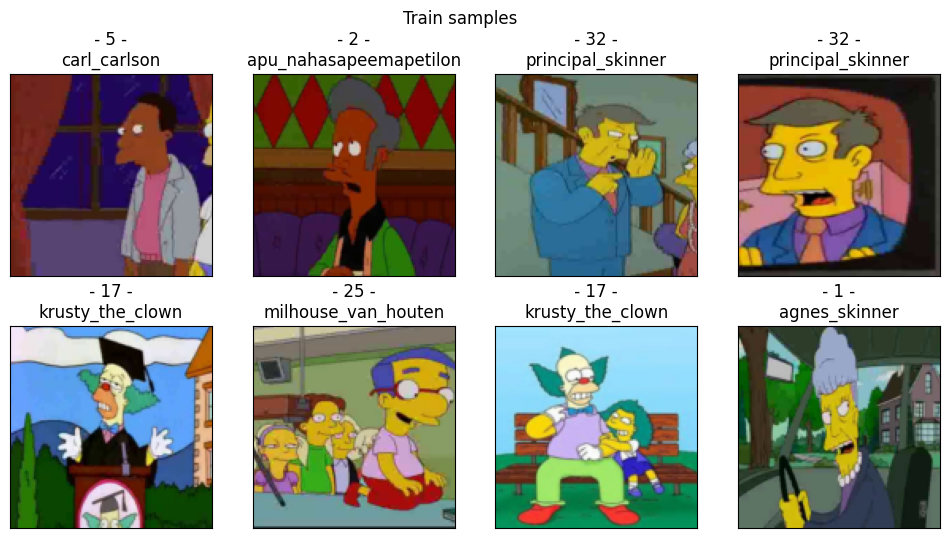

In [24]:
# Результат загрузки:
show_images(Train_dataset,'Train samples')

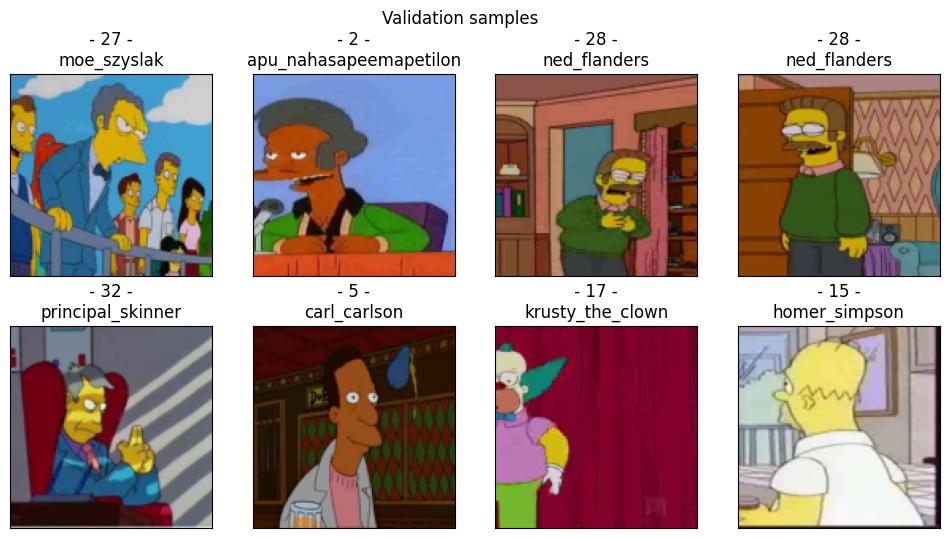

In [25]:
# Результат загрузки:
show_images(Val_dataset,'Validation samples')

### 2) Построение архитектуры сверточной сети.

In [26]:
def My_ConvBlock(in_channels, out_channels, aply_pool=False, max_pool_kernel_size = 0):
    # Слои
    layers_Block = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels,
                    out_channels,
                    kernel_size = 3,
                    padding = 1),
        torch.nn.BatchNorm2d(out_channels),
        torch.nn.ReLU(inplace=True),
      )
      # MaxPool
    if aply_pool:
        layers_Block.append(torch.nn.MaxPool2d(kernel_size = max_pool_kernel_size))
    return layers_Block

In [27]:
class ResNet9_Classifier(torch.nn.Module):
    def __init__(self, in_channels, num_classes):
        super(ResNet9_Classifier, self).__init__()

        self.conv1 = My_ConvBlock(in_channels, 64)

        self.conv2 = My_ConvBlock(64, 128, aply_pool=True, max_pool_kernel_size=2)

        self.res1 = torch.nn.Sequential(My_ConvBlock(128, 128),
                                        My_ConvBlock(128, 128))

        self.conv3 = My_ConvBlock(128, 256, aply_pool=True, max_pool_kernel_size=2)

        self.conv4 = My_ConvBlock(256, 512, aply_pool=True, max_pool_kernel_size=2)

        self.res2 = torch.nn.Sequential(My_ConvBlock(512, 512),
                                        My_ConvBlock(512, 512))

        self.classifier = torch.nn.Sequential(torch.nn.MaxPool2d(4),
                                        torch.nn.Flatten(),
                                        torch.nn.Linear(512 * 4 * 4, num_classes))

    def forward(self, X_batch):
        X_out = self.conv1(X_batch)
        X_out = self.conv2(X_out)

        X_out = self.res1(X_out) + X_out

        X_out = self.conv3(X_out)
        X_out = self.conv4(X_out)

        X_out = self.res2(X_out) + X_out

        X_out = self.classifier(X_out)
        return X_out

Создание модели:

In [28]:
My_ResNet_Classifier = ResNet9_Classifier(in_channels, num_classes)

In [30]:
# Вывод информации об архитектуре
My_ResNet_Classifier

ResNet9_Classifier(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU

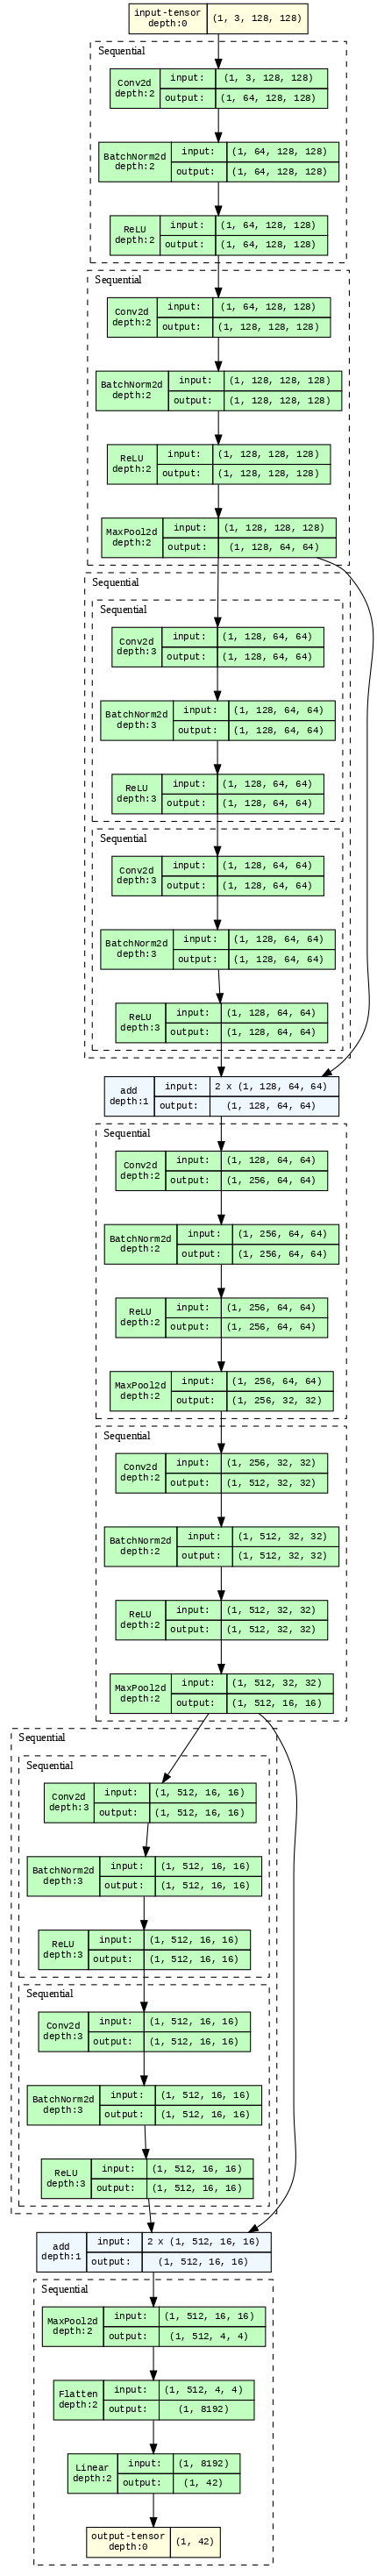

In [32]:
# Визуализация сети
graphviz.set_jupyter_format('png')
My_ResNet_Classifier_draw = draw_graph(My_ResNet_Classifier, input_size=(1,3, 128, 128), expand_nested=True)
My_ResNet_Classifier_draw.visual_graph

### 3) Обучение модели.

* Вывести ошибку классификации.

* Вывести время каждой эпохи, проведенной в процессе обучения модели на тренировочном наборе данных.

In [33]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
My_ResNet_Classifier.to(device)

optimizer = torch.optim.Adam(My_ResNet_Classifier.parameters(), lr = learning_rate)

loss_function = torch.nn.CrossEntropyLoss()

In [34]:
# ТРЕНИРОВКА
# Вычисление точности на пакете данных
def Accuracy_batch(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    return torch.tensor(torch.sum(predicted == labels).item() / len(predicted))

# Вычисление точности всех пакетов (на одной эпохе обучения)
def Accuracy_epoch(acc_batches):
    return torch.stack(acc_batches).mean()

# Вычисление функции-потерь всех пакетов (на одной эпохе обучения)
def Loss_epoch(loss_batches):
    return torch.stack(loss_batches).mean()

In [35]:
def TrainModel(modelTrain, data, epoch_count, loss_func_batch, optimizer, device):
    print("Обучение:")
    print(' Эпохи:')
    # Устанавливаем время общего обучения
    all_train_time = time.time()
    # Обучение на эпохах
    for epoch in range(epoch_count):
        # Устанавливаем время обучения одной эпохи
        epoch_time = time.time()
        # Точность и потери всех пакетов эпохи
        loss_all_batch = []
        acc_all_batch = []
        # Проход по пакетам данных
        for _, (images, labels) in enumerate(data):

            img_batch = images.to(device)
            labels_batch = labels.to(device)

            optimizer.zero_grad()

            outputs_batch = modelTrain(img_batch)

            loss_batch = loss_func_batch(outputs_batch, labels_batch)
            loss_all_batch.append(loss_batch)

            acc_batch = Accuracy_batch(outputs_batch, labels_batch)
            acc_all_batch.append(acc_batch)

            loss_batch.backward()
            optimizer.step()

        epoch_time = time.time() - epoch_time

        # Loss (all batches) epoch
        loss_epoch = Loss_epoch(loss_all_batch)
        # Accuracy (all batches) epoch
        acc_epoch = Accuracy_epoch(acc_all_batch)

        # Вывод информации
        print(f'   Эпоха[{epoch + 1}]:')
        print(f'      Loss = {(loss_epoch):.6}. Точность = {(acc_epoch * 100):.6}%. Время = {epoch_time:.4}s, или {(epoch_time / 60):.4}min')

    all_train_time = time.time() - all_train_time
    print(f'Общее время обучения = {all_train_time:.6}s, или {(all_train_time / 60):.4}min')

In [36]:
TrainModel(My_ResNet_Classifier, Train_loader, epoch_count, loss_function, optimizer, device)

Обучение:
 Эпохи:
   Эпоха[1]:
      Loss = 2.74469. Точность = 42.6002%. Время = 224.8s, или 3.746min
   Эпоха[2]:
      Loss = 0.818583. Точность = 77.4851%. Время = 235.1s, или 3.919min
   Эпоха[3]:
      Loss = 0.493368. Точность = 86.2488%. Время = 223.2s, или 3.721min
   Эпоха[4]:
      Loss = 0.344567. Точность = 90.4061%. Время = 221.8s, или 3.697min
   Эпоха[5]:
      Loss = 0.249625. Точность = 92.9443%. Время = 221.2s, или 3.687min
   Эпоха[6]:
      Loss = 0.188076. Точность = 94.7%. Время = 221.3s, или 3.688min
   Эпоха[7]:
      Loss = 0.14916. Точность = 95.7115%. Время = 220.7s, или 3.678min
   Эпоха[8]:
      Loss = 0.117268. Точность = 96.6543%. Время = 220.7s, или 3.679min
   Эпоха[9]:
      Loss = 0.0966753. Точность = 97.2537%. Время = 220.4s, или 3.674min
   Эпоха[10]:
      Loss = 0.0804918. Точность = 97.7547%. Время = 221.3s, или 3.689min
   Эпоха[11]:
      Loss = 0.0755509. Точность = 97.8137%. Время = 221.0s, или 3.684min
   Эпоха[12]:
      Loss = 0.0635064

### 4) Тестирование модели.

* По завершении обучения должна быть выведена F1-score('weighted') на тестовом наборе данных.


In [37]:
# ТЕСТИРОВАНИЕ
# Вычисление функции-потерь
def get_loss(model, data_loader, device):
    loss = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            loss += loss_function(outputs, labels)
            n += labels.size(0)
    return loss / n

# F1-scope
def get_f1_scope(model, data_loader, device):
    tp = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)
            n += labels.size(0)
            tp += (predicted == labels).sum()
    precision = tp / n
    recall = tp / n
    return 2 * precision * recall / (precision + recall)


In [39]:
print(f'Тестовая выборка:')
acc_f1_test = get_f1_scope(My_ResNet_Classifier, Val_loader, device)
print(f'  Точность F1-scope = {(acc_f1_test * 100):.6}%.')
loss_test = get_loss(My_ResNet_Classifier, Val_loader, device)
print(f'  Loss = {((loss_test)):.6}%.')

Тестовая выборка:
  Точность F1-scope = 98.7103%.
  Loss = 0.00126846%.
